<a href="https://colab.research.google.com/github/MemonML/datascience_bootcamp/blob/main/day_25_MRI_brain_tumor_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.1

# Import needed modules

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Merging two data sets training and testing into one folder


In [ ]:
import os
import shutil

def merge_folders(source_folder1, source_folder2, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Merge files from the first source folder
    for item in os.listdir(source_folder1):
        source_item = os.path.join(source_folder1, item)
        destination_item = os.path.join(destination_folder, item)
        if os.path.isfile(source_item):
            shutil.copy(source_item, destination_item)

    # Merge files from the second source folder
    for item in os.listdir(source_folder2):
        source_item = os.path.join(source_folder2, item)
        destination_item = os.path.join(destination_folder, item)
        if os.path.isfile(source_item):
            shutil.copy(source_item, destination_item)

if __name__ == "__main__":
    training_folder = "/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/mri_dataset/Training"
    testing_folder = "/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/mri_dataset/Testing"
    merged_folder = "/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/consolidate_train_test"

    merge_folders(training_folder, testing_folder, merged_folder)
    print("Data merged successfully.")


Data merged successfully.


# Data Preprocessing
##Read data and store it in dataframe

In [ ]:
data_dir = '/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/mri_dataset/Training'
data_dir2 = '/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/mri_dataset/Testing'


filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
len(df)

2870

In [ ]:
Fseries.shape

(2870,)

# Split dataframe into train, valid, and test

In [ ]:
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 123)

#Create image data generator

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 2296 validated image filenames belonging to 4 classes.
Found 287 validated image filenames belonging to 4 classes.
Found 287 validated image filenames belonging to 4 classes.


# Show sample from train data

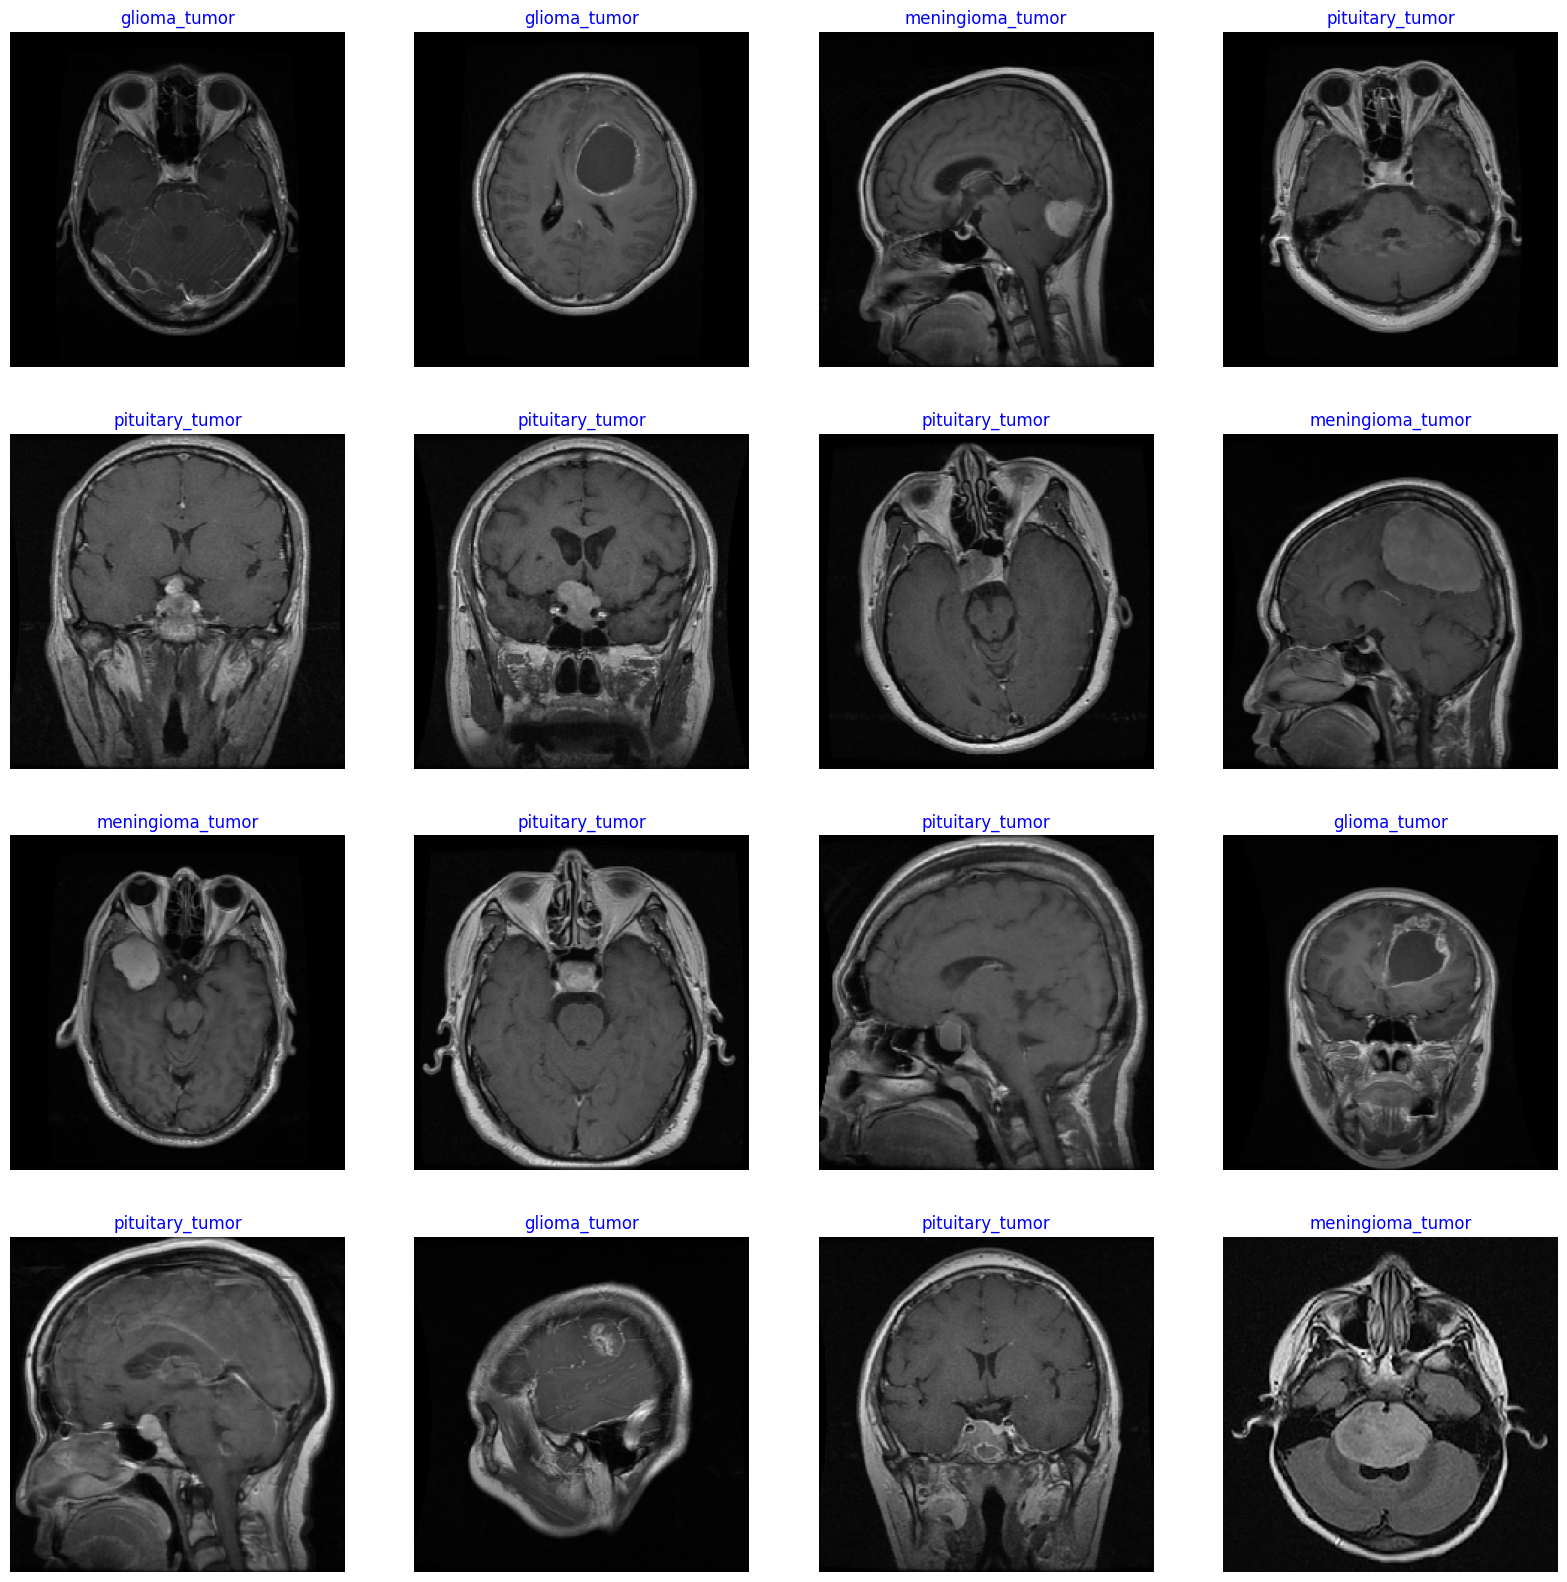

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


#Model Structure

## Generic Model Creation

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4,383,655
Trainable params: 4,339,072
Non-trainable params: 44,583
_________________________________________

# Model Training

In [ ]:
epochs = 1   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

144/144 [==============================] - 238s 2s/step - loss: 5.0229 - accuracy: 0.7983 - val_loss: 3.0531 - val_accuracy: 0.9094


# Display model performance

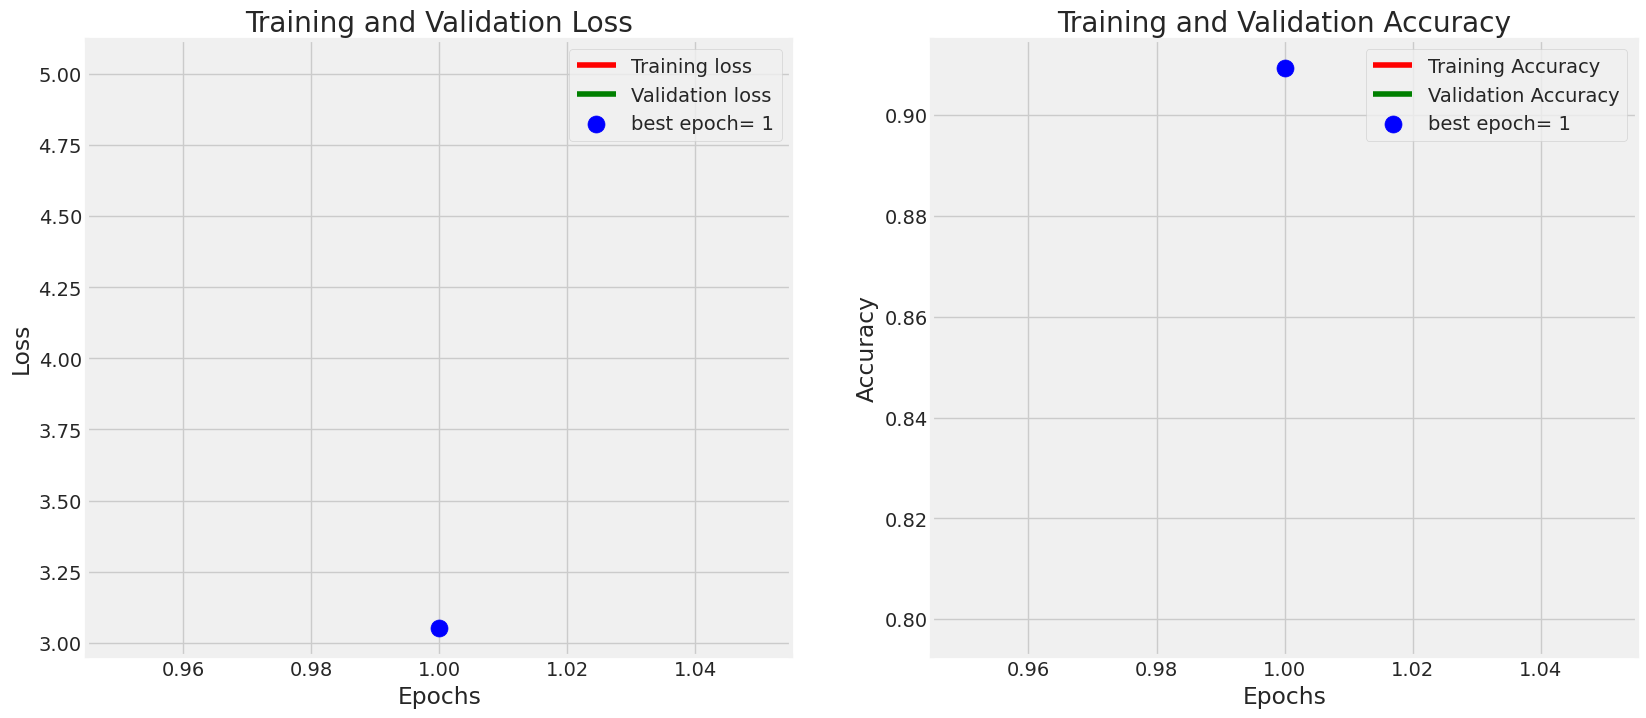

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


# Evaluate Model

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 35s 6s/step - loss: 3.0605 - accuracy: 0.8839
Train Loss:  3.040452241897583
Train Accuracy:  0.9196428656578064
--------------------
Validation Loss:  3.0544791221618652
Validation Accuracy:  0.9017857313156128
--------------------
Test Loss:  3.0605108737945557
Test Accuracy:  0.8839285969734192


# Get Predictions

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion Matrics and Classification Report

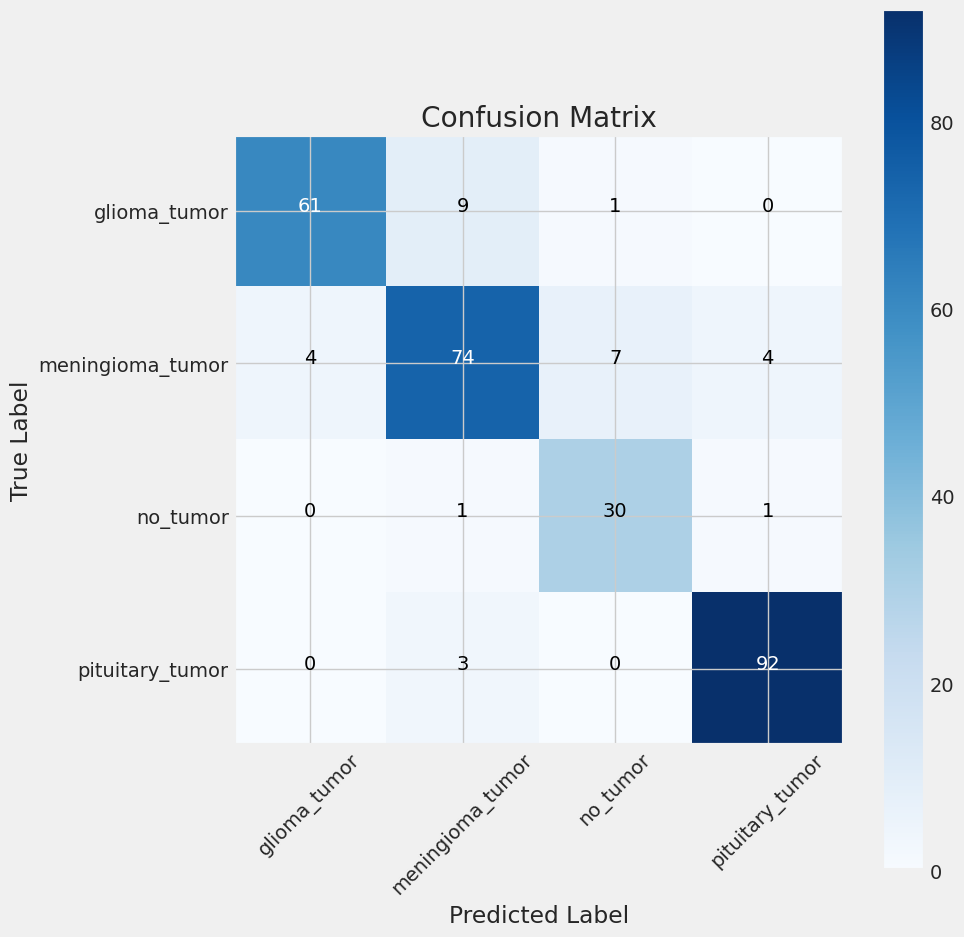

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.86      0.90        71
meningioma_tumor       0.85      0.83      0.84        89
        no_tumor       0.79      0.94      0.86        32
 pituitary_tumor       0.95      0.97      0.96        95

        accuracy                           0.90       287
       macro avg       0.88      0.90      0.89       287
    weighted avg       0.90      0.90      0.90       287



# Save model

In [ ]:
#Save the model
model.save('/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/Brain_Tumors.h5')

# Prediction using loaded_model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/Brain_Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/Data_Science_Boot_Camp/week6/day_25/mri_dataset/Testing/meningioma_tumor/image(1).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['no', 'yes']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
yes
